## Project Milestone 4 - Linguistic Harbingers of Betrayal Extension

First, input all the libraries we need to get the plot:

In [1]:
import json

from scipy.stats import sem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Since the data file contains only the selected games, there is no need to consider the selection criteria when retreving the message data. 
*The condition "relationships that contain at least two consecutive and reciprocated acts of support that span at least three seasons in game time, with no more than five seasons passing between two acts of friendship" is fullfilled.

Here, we read the data from json file and get the number of games, which is 500, including 250 selected games ended up betrayal and 250 selected games ended up lasting friendship between two players.


In [2]:
# read data from diplomacy_data.json with reading mode
with open("diplomacy_data.json", "r") as f:
        data = json.load(f)
len(data)

500

Since we only consider dialogs that happen before the last act of friendship, we need to know when does the last act of friendship happen. Later when extracting feature values, extract them from the seasons that is before the last support season.

In [3]:
# a function to get the season where the last support between two players happened
# entry refer to one entry in the dataset, one game
def last_support(entry):
    seasons = entry['seasons']
    last_support = None
    for season in seasons[:-1]:
        if 'support' in season['interaction'].values():
            last_support = season['season']
    return last_support

Given the messages sent by a player from a season in a game, we need to calculate the different variable values of the messages.

Variables we consider:

1. sent_pos: Positive sentiment
2. sent_neu: Neutral sentiment
3. sent_neg: Negative sentiment
4. discourse_comp: Discourse complexity (calculated through comparison, contingency, expansive and temporal)
5. plan: Planning level (calculated through future)
6. argu_level: Argumentation level (calculated through claim and premise)
7. n_request: Number of requests
8. politeness: Politeness
9. subj: Subjectivity
10. n_words: Number of words
11. n_sentences: Number of sentences


In [4]:
# a function to get the average value across the seasons for all features of the messages
# msgs: messages sent by a player from a season in a game
def extract_features(msgs):
    n_sents = sum(m['n_sentences'] for m in msgs) * 1.0
    
    # Sentiment
    # compute positive sentiment score
    sent_pos = sum(m['sentiment'].get("positive") for m in msgs) / len(msgs)
    # compute neutral sentiment score
    sent_neu = sum(m['sentiment'].get("neutral") for m in msgs) / len(msgs)
    # compute positive sentiment score
    sent_neg = sum(m['sentiment'].get("negative") for m in msgs) / len(msgs)
    
    # Argumentation and Discourse
    # compute discourse complexity through comparison, contingency, expansive and temporal
    comparison = sum(len(m['lexicon_words'].get("disc_comparison", []))for m in msgs) / n_sents
    contingency = sum(len(m['lexicon_words'].get("disc_contingency", []))for m in msgs) / n_sents
    expansive = sum(len(m['lexicon_words'].get("disc_expansion", []))for m in msgs) / n_sents
    temporal = sum(len(m['lexicon_words'].get("disc_temporal_rest", []))for m in msgs) / n_sents
    discourse_comp = comparison+contingency+expansive+temporal
    # compute the average number of markers refer to future
    plan = sum(len(m['lexicon_words'].get("disc_temporal_future", []))for m in msgs) / n_sents
    # compute argumentation level through claim and premise
    claim = sum(len(m['lexicon_words'].get("claim", []))for m in msgs) / n_sents
    premise = sum(len(m['lexicon_words'].get("premise", []))for m in msgs) / n_sents
    argu_level = claim+premise
    # compute average number of request
    n_request = sum(m['n_requests'] for m in msgs) / len(msgs)
    
    # Politeness
    politeness = sum(m['politeness'] for m in msgs) / len(msgs)
    
    # Subjectivity using allsubj
    subj = sum(len(m['lexicon_words'].get("allsubj", []))for m in msgs) / n_sents
    
    # Talkativeness
    # compute average number of words
    n_words = sum(m['n_words'] for m in msgs) / len(msgs)
    # compute average number of sentences
    n_sentences = sum(m['n_sentences'] for m in msgs) / len(msgs)

    return dict(
        sentPos = sent_pos,
        sentNeu = sent_neu,
        sentNeg = sent_neg,
        discourseComp = discourse_comp,
        plan = plan,
        arguLevel = argu_level,
        nRequest = n_request,
        politeness = politeness,
        subjectivity = subj,
        nWords = n_words,
        nSentences = n_sentences)

From paper: To ensure that we are studying conversational patterns that occur only when the two individuals in the dyad are ostensibly being friends, we only extract features from the messages exchanged before the last act of friendship.
Therefore, the messages we extract should from seasons less than last support season.

In [5]:
# a function to get average politeness scores from dataset entries 
# data: the dataset where we extract politeness score from
# betrayal: if the games we consider end up betrayal
# betrayer: if the person to be analyzed is the (potential) betrayer
def process_data(data, betrayal, betrayer):
    results = []
    
    # loop in every game in data
    for entry in data:
        for season in entry['seasons']:
            # consider every season in the game, extract features from the messages exchanged before the last act of friendship
            if(season['season'] <= last_support(entry)):
                if(len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0):
                    if(entry['betrayal'] == betrayal):
                        if(betrayer):
                            results.append(extract_features(season['messages']['betrayer']))
                        else:
                            results.append(extract_features(season['messages']['victim']))
    # return value is a list of features of the indicated player in the indicated type of games
    return results

Get the politeness score of the four conditions below:

In [17]:
# for the games end up betrayal, get politeness score for each betrayer
betray_er = pd.DataFrame(process_data(data, True, True))

# for the games end up betrayal, get politeness score for each victim
betray_vi = pd.DataFrame(process_data(data, True, False)) 

# for the games not end up betrayal, get politeness score for each potential betrayer
control_er = pd.DataFrame(process_data(data, False, True))

# for the games not end up betrayal, get politeness score for each potential victim
control_vi = pd.DataFrame(process_data(data, False, False)) 

In [18]:
betray_er

,sentPos,sentNeu,sentNeg,discourseComp,plan,arguLevel,nRequest,politeness,subjectivity,nWords,nSentences
0,1.333333,1.333333,1.500000,0.680000,0.120000,0.320000,3.666667,0.803328,3.680000,81.500000,4.166667
1,0.142857,0.857143,1.285714,0.375000,0.125000,0.250000,1.285714,0.560083,2.125000,40.000000,2.285714
2,2.000000,2.500000,2.000000,1.538462,0.307692,0.461538,5.500000,0.982703,4.384615,166.500000,6.500000
3,1.800000,0.800000,2.200000,0.958333,0.208333,0.291667,3.200000,0.748802,3.416667,89.800000,4.800000
4,1.000000,1.000000,1.000000,0.333333,0.166667,0.333333,2.000000,0.899161,3.166667,39.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...
658,1.666667,3.000000,4.000000,0.730769,0.076923,0.384615,3.000000,0.395679,2.692308,136.333333,8.666667
659,2.000000,1.000000,2.000000,1.400000,0.400000,0.200000,2.000000,0.785834,2.200000,71.000000,5.000000
660,0.500000,1.500000,3.500000,0.090909,0.000000,0.090909,2.000000,0.354644,1.545455,62.000000,5.500000
661,0.500000,0.500000,1.250000,0.000000,0.000000,0.111111,1.000000,0.510478,1.222222,21.500000,2.250000


In [8]:
betray_vi

,sentPos,sentNeu,sentNeg,discourseComp,plan,arguLevel,nRequest,politeness,subjectivity,nWords,nSentences
0,1.500000,1.250000,5.000000,0.483871,0.129032,0.677419,3.250000,0.809993,2.193548,120.000000,7.750000
1,1.333333,0.666667,1.000000,0.000000,0.000000,0.111111,0.666667,0.785508,1.555556,31.000000,3.000000
2,1.000000,3.666667,4.666667,0.178571,0.035714,0.214286,3.666667,0.607331,1.571429,120.000000,9.333333
3,1.000000,0.000000,2.000000,0.833333,0.333333,0.500000,0.500000,0.571134,1.833333,28.000000,3.000000
4,0.666667,1.666667,2.666667,0.266667,0.133333,0.266667,2.333333,0.563423,1.866667,85.333333,5.000000
...,...,...,...,...,...,...,...,...,...,...,...
658,1.500000,3.000000,1.500000,0.125000,0.000000,0.125000,3.500000,0.787815,1.625000,75.000000,6.000000
659,0.000000,1.333333,0.666667,0.000000,0.000000,0.333333,0.333333,0.345412,0.333333,7.666667,2.000000
660,0.500000,2.000000,4.000000,0.538462,0.153846,0.384615,2.000000,0.522554,1.461538,75.000000,6.500000
661,0.250000,3.000000,1.250000,0.388889,0.111111,0.166667,2.000000,0.501783,0.944444,34.750000,4.500000


In [9]:
control_er

,sentPos,sentNeu,sentNeg,discourseComp,plan,arguLevel,nRequest,politeness,subjectivity,nWords,nSentences
0,0.0,1.0,1.0,1.500000,0.500000,0.000000,2.0,0.448337,0.000000,14.0,2.0
1,0.0,0.0,1.0,0.000000,0.000000,0.500000,1.0,0.511553,3.000000,11.0,1.0
2,0.0,1.0,1.0,0.000000,0.000000,0.000000,1.0,0.390865,0.000000,17.0,2.0
3,0.0,0.5,1.0,0.333333,0.000000,0.000000,0.5,0.608813,1.666667,17.5,1.5
4,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.384741,3.000000,50.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
714,0.0,0.0,1.0,0.000000,0.000000,0.000000,1.0,0.208446,1.000000,14.0,1.0
715,1.0,6.0,1.0,0.375000,0.000000,0.375000,3.0,0.934349,2.125000,111.0,8.0
716,3.0,5.0,8.0,0.562500,0.250000,0.687500,8.0,0.910394,3.250000,305.0,16.0
717,0.0,3.0,6.0,0.888889,0.333333,0.888889,6.0,0.822667,4.666667,215.0,9.0


In [10]:
control_vi

,sentPos,sentNeu,sentNeg,discourseComp,plan,arguLevel,nRequest,politeness,subjectivity,nWords,nSentences
0,0.0,3.0,1.0,1.750,0.250,0.000000,1.0,0.447457,0.75,47.0,4.0
1,0.0,1.0,0.0,0.000,0.000,0.000000,1.0,0.376480,0.00,8.0,1.0
2,0.0,0.0,1.0,0.000,0.000,0.000000,0.0,0.441322,1.00,5.0,1.0
3,1.0,1.0,0.0,1.000,0.500,0.500000,2.0,0.975253,2.00,23.0,2.0
4,0.0,0.0,1.0,0.000,0.000,1.000000,0.0,0.381919,0.00,28.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
714,1.0,0.5,2.5,0.625,0.375,0.500000,1.0,0.627844,2.25,44.0,4.0
715,0.0,1.0,0.0,0.000,0.000,0.000000,1.0,0.474890,0.00,10.0,1.0
716,1.0,1.0,2.0,0.000,0.000,0.000000,2.0,0.856649,3.00,56.0,4.0
717,2.0,0.0,1.0,0.000,0.000,0.333333,0.0,0.794841,1.00,20.0,3.0


<AxesSubplot:>

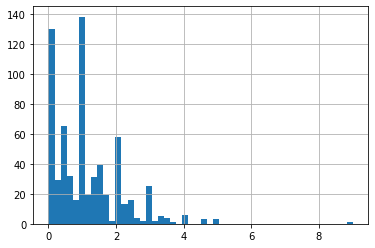

In [11]:
betray_er['sentPos'].hist(bins = 50)

Text(0, 0.6, 'Number of movies')

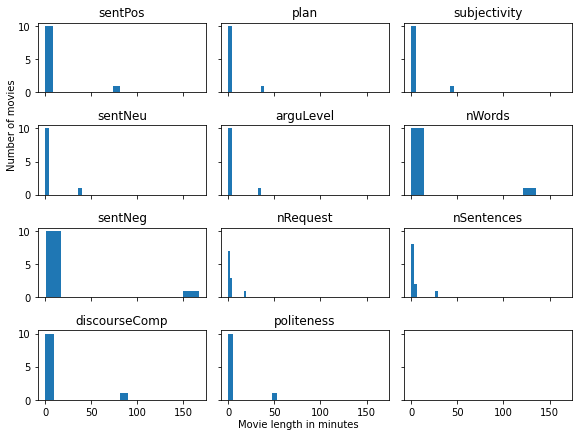

In [36]:
import math
fig, ax = plt.subplots(4,3,figsize= (8,6), sharey = True, sharex = True)

for x,i in zip(betray_er.columns,range(12)):
    sbplt = ax[i%4, math.floor(i/4)]
    sbplt.hist(betray_er.iloc[i].values,bins = 10)
    sbplt.set_title(x)
    
fig.tight_layout()

fig.text(0.4,0, "Movie length in minutes")
fig.text(0,0.6, "Number of movies", rotation = 90)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

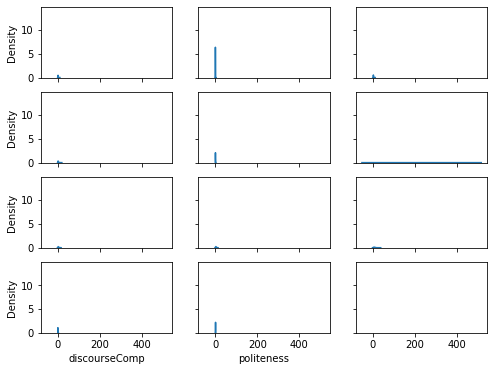

In [40]:
import seaborn as sns
fig, ax = plt.subplots(4,3,figsize= (8,6), sharey = True, sharex = True)
for x,i in zip(betray_er.columns,range(12)):
    sbplt = ax[i%4, math.floor(i/4)]
    sns.distplot(betray_er[x],ax=sbplt)

In [25]:
betray_er.columns

Index(['sentPos', 'sentNeu', 'sentNeg', 'discourseComp', 'plan', 'arguLevel',
       'nRequest', 'politeness', 'subjectivity', 'nWords', 'nSentences'],
      dtype='object')

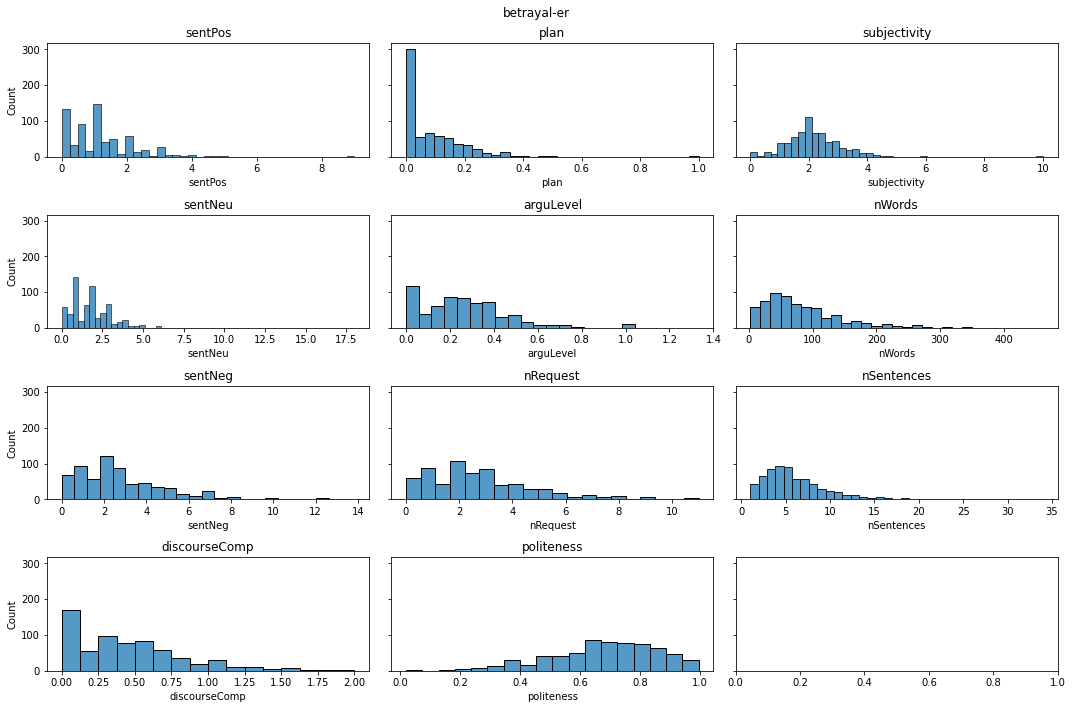

In [67]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharey=True)
fig.suptitle('betrayal-er')
for x,i in zip(betray_er.columns,range(12)):
    sns.histplot(betray_er[x],ax=axes[i%4, math.floor(i/4)]).set_title(x)
    fig.tight_layout()

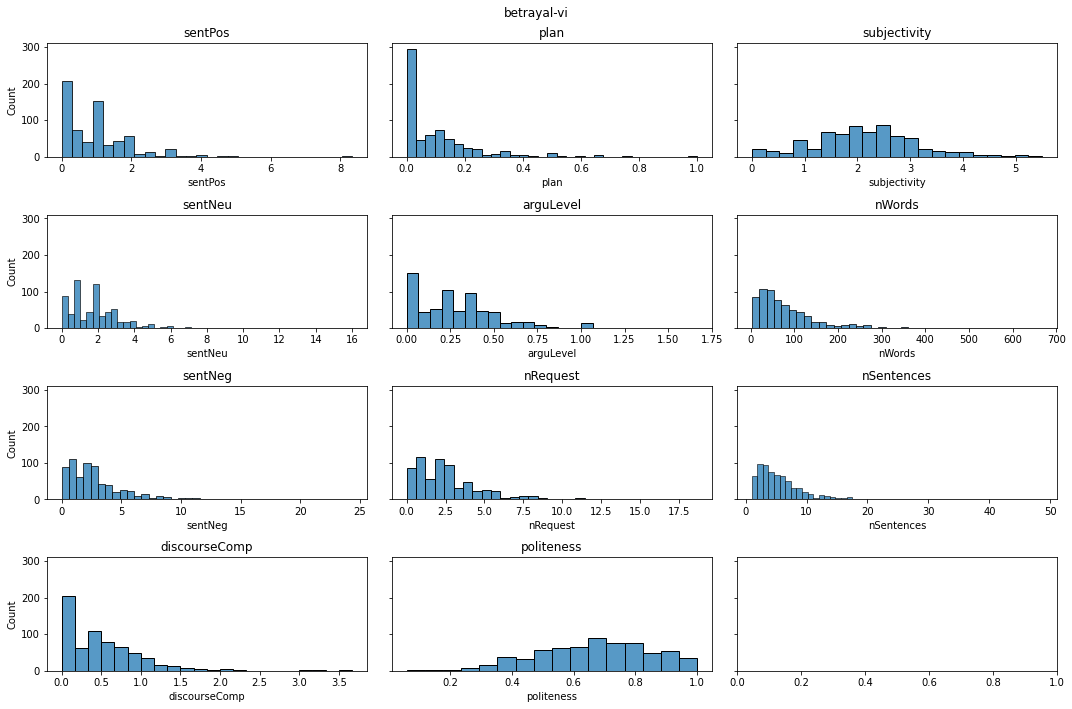

In [68]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharey=True)
fig.suptitle('betrayal-vi')
for x,i in zip(betray_vi.columns,range(12)):
    sns.histplot(betray_vi[x],ax=axes[i%4, math.floor(i/4)]).set_title(x)
    fig.tight_layout()

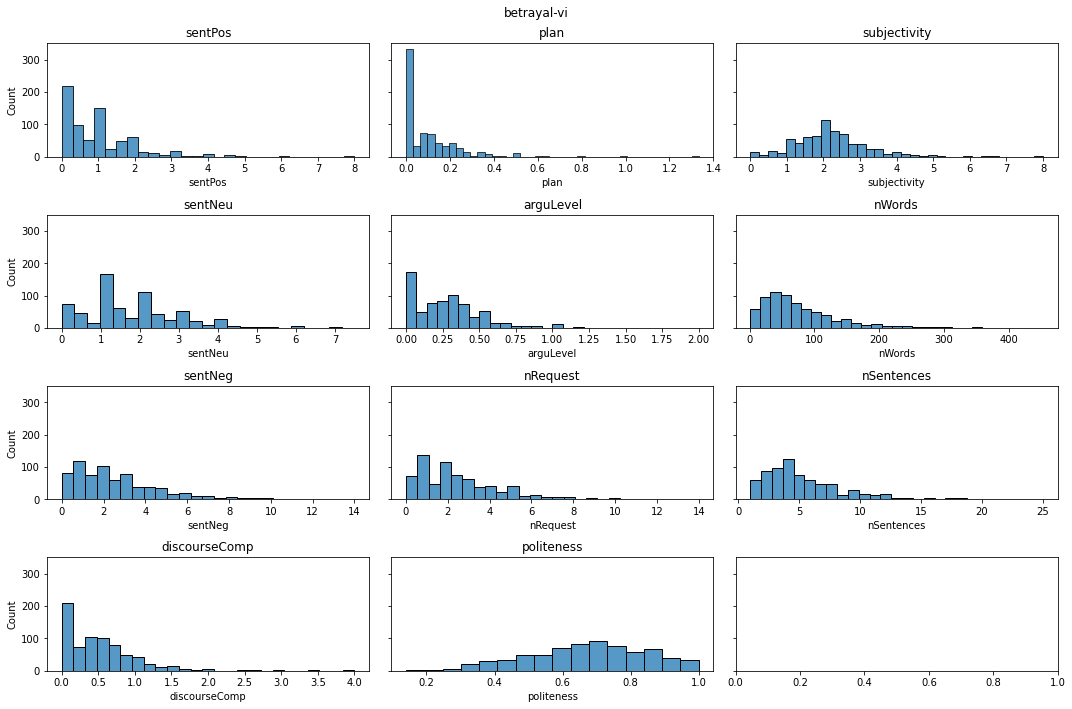

In [69]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharey=True)
fig.suptitle('betrayal-vi')
for x,i in zip(control_er.columns,range(12)):
    sns.histplot(control_er[x],ax=axes[i%4, math.floor(i/4)]).set_title(x)
    fig.tight_layout()

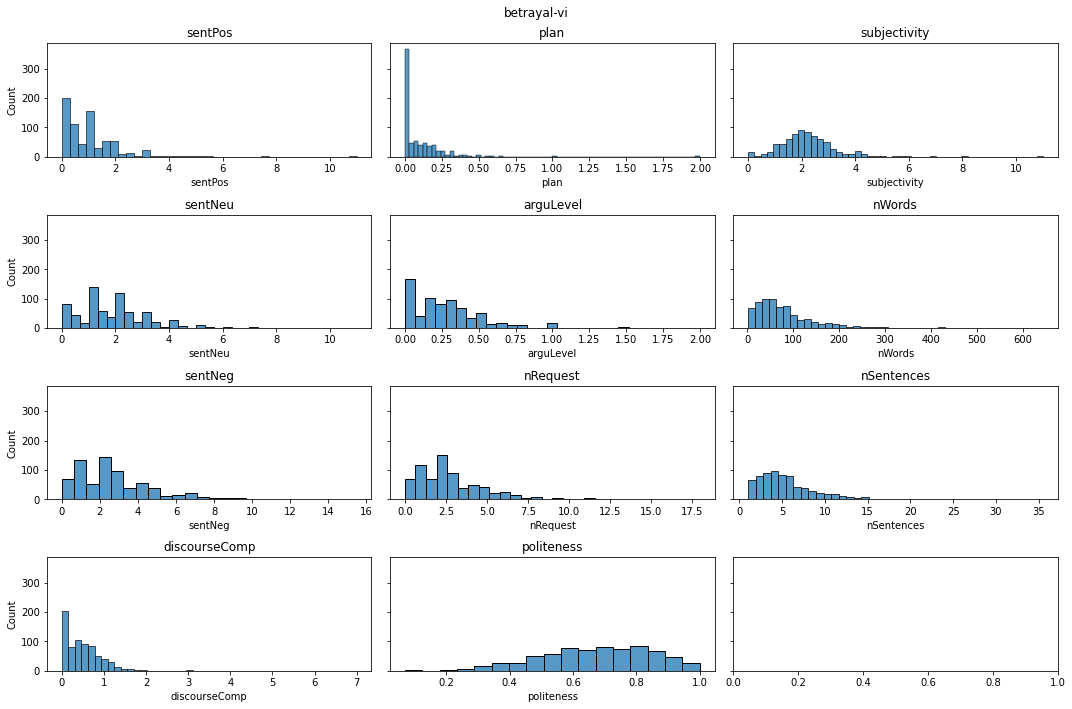

In [70]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharey=True)
fig.suptitle('betrayal-vi')
for x,i in zip(control_vi.columns,range(12)):
    sns.histplot(control_vi[x],ax=axes[i%4, math.floor(i/4)]).set_title(x)
    fig.tight_layout()

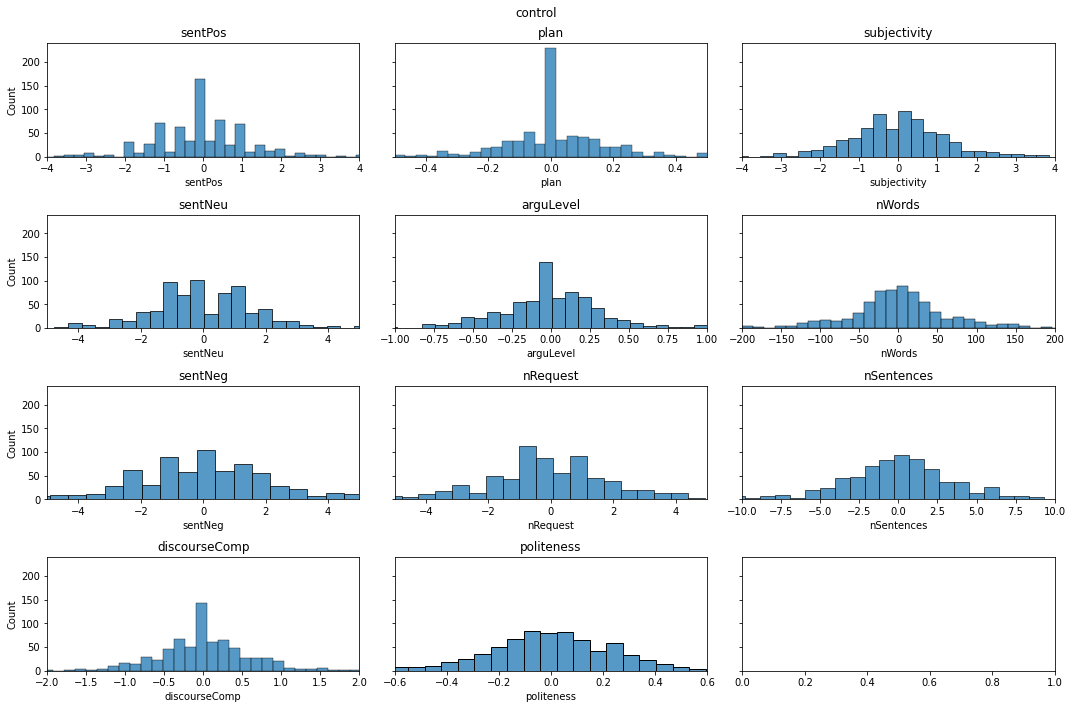

In [91]:
xrange=[(-4, 4),(-5,5),(-5,5),(-2,2),(-0.5,0.5),(-1,1),(-5,5),(-0.6,0.6),(-4,4),(-200,200),(-10,10)]
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharey=True)
fig.suptitle('control')
for x,i in zip(control_vi.columns,range(12)):
    sns.histplot(control_er[x]-control_vi[x],ax=axes[i%4, math.floor(i/4)]).set_title(x)
    ax=axes[i%4, math.floor(i/4)].set(xlim=xrange[i])
    ax=axes[i%4, math.floor(i/4)].set(ylim=(0,240))
    fig.tight_layout()

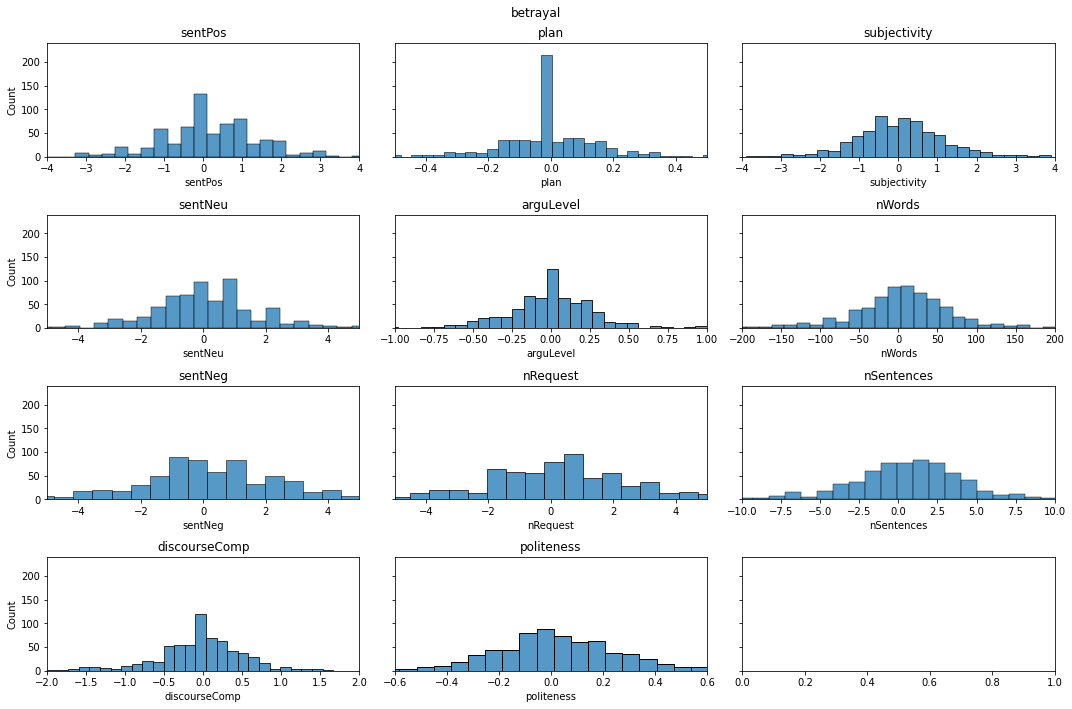

In [92]:
xrange=[(-4, 4),(-5,5),(-5,5),(-2,2),(-0.5,0.5),(-1,1),(-5,5),(-0.6,0.6),(-4,4),(-200,200),(-10,10)]
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharey=True)
fig.suptitle('betrayal')
for x,i in zip(betray_vi.columns,range(12)):
    sns.histplot(betray_er[x]-betray_vi[x],ax=axes[i%4, math.floor(i/4)]).set_title(x)
    ax=axes[i%4, math.floor(i/4)].set(xlim=xrange[i])
    ax=axes[i%4, math.floor(i/4)].set(ylim=(0,240))
    fig.tight_layout()

In [94]:
betrayal_imbalance=betray_er-betray_vi
control_imbalance=control_er-control_vi

In [117]:
betrayal_imbalance['betrayal']=1
control_imbalance['betrayal']=0
                   
frames = [betrayal_imbalance, control_imbalance]
imbalance = pd.concat(frames)
imbalance.columns

Index(['sentPos', 'sentNeu', 'sentNeg', 'discourseComp', 'plan', 'arguLevel',
       'nRequest', 'politeness', 'subjectivity', 'nWords', 'nSentences',
       'betrayal'],
      dtype='object')

In [159]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 

In [185]:
# 将数据集拆分为训练集和测试集
X = imbalance.drop('betrayal', axis = 1)
y = imbalance['betrayal']

# 训练集与测试集的比例为75%和25%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state=0)

In [186]:
logistic = smf.logit('betrayal~nRequest+nWords+nSentences+sentNeg:nSentences', data = pd.concat([y_train,X_train], axis = 1)).fit()

logistic.summary()

Optimization terminated successfully.
         Current function value: 0.687102
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               betrayal   No. Observations:                 1243
Model:                          Logit   Df Residuals:                     1238
Method:                           MLE   Df Model:                            4
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                0.006382
Time:                        21:12:27   Log-Likelihood:                -854.07
converged:                       True   LL-Null:                       -859.55
Covariance Type:            nonrobust   LLR p-value:                   0.02690
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1397      0.060     -2.329      0.020      -0.257      -0.022
nRequest               0.0683      0.043      1.571      0.116      -0.017       0.153
nWords                -0.0036      0.002     -2.108      0.035      -0.007      -0.000
nSentences             0.0538      0.031      1.729      0.084      -0.007       0.115
sentNeg:nSentences     0.0022      0.002      1.238      0.216      -0.001       0.006
======================================================================================
"""

In [183]:
# 根据分类器，在测试集上预测概率
prob = logistic.predict(exog = X_test.drop(columns=[ 'sentNeu', 'discourseComp', 'plan', 'arguLevel', 'politeness', 'subjectivity'], axis = 1))
# 根据概率值，将观测进行分类，不妨以0.5作为阈值
pred = np.where(prob >= 0.45, 1, 0)

# 根据预测值和实际值构建混淆矩阵
cm = metrics.confusion_matrix(y_test, pred, labels=[0,1])
cm
# 计算模型的准确率
accuracy = cm.diagonal().sum()/cm.sum()
accuracy

0.5107913669064749

<Figure size 432x288 with 0 Axes>

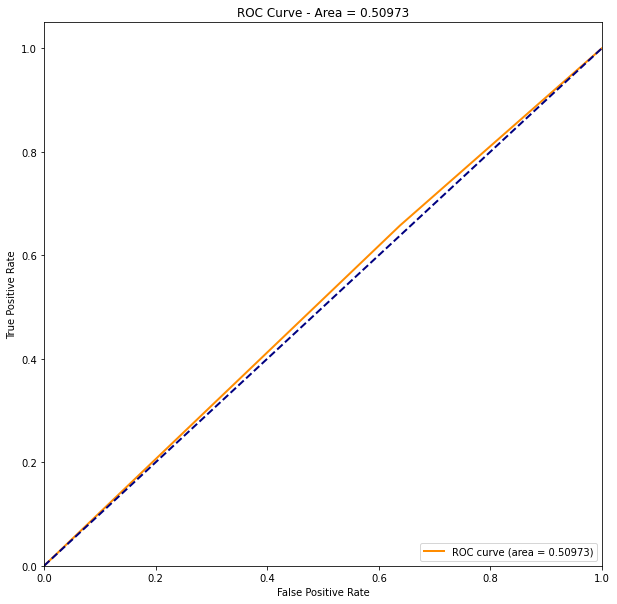

In [184]:
#Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, pred) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Area = {:.5f}".format(roc_auc))
plt.legend(loc="lower right")
plt.show()

In [195]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
# rf= RandomForestClassifier(n_estimators=1000,max_depth=15,criterion='gini')
logistic_2 = LogisticRegression(solver='lbfgs')

predicted = cross_validate(logistic_2, imbalance[['nRequest','nSentences']], imbalance['betrayal'], cv=5)
np.mean(predicted['test_score'])

0.5405587819808508